
# Goal of the task

Process and detect muscle fatigue in EMG signals recorded from one human subject. (cite - Neuroengineer-task.pdf)

My interpretation: Given the EMG data of a subject, classify the patient's state of fatigue (fatigue or no fatigue).

### Note:
1. All functions are in utils.py. 

2. Playground is the jupyter notebook I used for playing around with the data and brainstorming ideas. 

3. Task2_final is the jupyter notebook used for the demonstration of the finalised preprocessing steps and model performance 

In [10]:
from utils import read_and_structure_data, extract_features

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda
from sklearn.linear_model import LogisticRegression as lr
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random


### Step 1: Load in the data of 1 subject

I observed that 2 files were empty and discarded them. U1Ex1Rep3.csv, U3Ex2Rep3.csv

In [2]:
data_folder = "/home/nayanika/myelin-h/neuroengineering/EMG-data-task2/EMG/EMG"

ID = "U7" # select a subject ID

data = read_and_structure_data(data_folder, ID)

### Step 2: Preprocess the data and extract features

#### Steps followed for preprocessing:

1. Bandpass filter with window 30 - 300 Hz (analysed by visually plotting fft of the data)
2. Rectify the signal (take absolute value)
3. Moving RMS using 50 ms sliding window

step 2 and 3 was used during ideation and brainstorming but was not ultimately used

#### Feature Extraction
Computed power spectral density using a window length of 256 points. PSD was chosen because I observed that each session has varying lengths of fatigue and no fatigue periods and thus comparing temporal features was not possible. PSD can be used for comparing signals of varying length and thus was a suitable tool in this case. MOreover, there was a clear difference in the PSD of fatigue vs no fatigue segments. 

#### Data Augumentation 
The goal states that classification must be done using only 1 subject, 9 exampled were very less for any machine learning model. Thus, I chose to used data augmentation for increasing the number of sampled. For augmentation, a sliding window of 1 second (2000 samples) with a overlap of 0.5 seconds was used. It was ensured taht periods of fatigue and no fatigue did not exist in a single window. The PSD for the entire fatigue period in a session was compared to that of a few random windows to ensure that 1 second wa sufficient to capture all the required information. 

function used: bandpass_filter(), sliding_window_rms(), extract_features(), extract_windows_and_compute_psd()

In [3]:
data_preprocessed, features, labels = extract_features(data, fs=2000)

### Step 3: Linear Machine Learning Model

I used PCA to identify top 10 salient features and these used those for Linear Discriminant Analysis for classifying the data each window(1 second) into fatigue or no fatigue. PCA was used because the PSD returns 129 features, thus making the ratio of features to data (even after augmentation) 1:3. Ideally 1:10 is optimal.

5 random seeds were used to ensure that the model was effective and robust. Confusion matrix and ROC curve was used to measure the efficacy of the model.



(171, 129)
Confusion Matrix:
[[16  5]
 [ 1 13]]
Accuracy: 82.86%


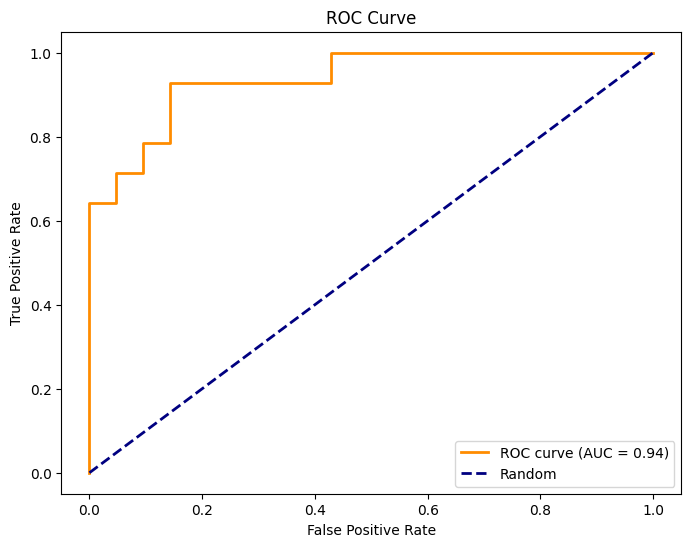

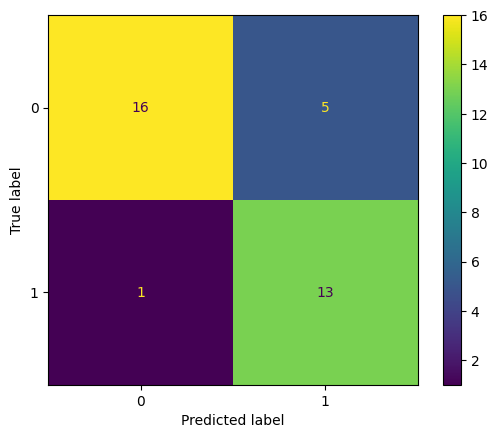

In [4]:
# PCA
pca = PCA(n_components=features[1].shape[0])
features_pca = pca.fit_transform(features)
print(features_pca.shape)
components = np.sum(pca.explained_variance_ratio_>0.004)
# print(components)

X_train, X_test, Y_train, Y_test = train_test_split(features_pca[:,0:10], labels, test_size=0.2, random_state=4)


# LDA classifier
lda_model = lda()
lda_model.fit(X_train, Y_train)

# predict calss
Y_pred = lda_model.predict(X_test)
Y_probs = lda_model.predict_proba(X_test)[:, 1]

# performance metrics
conf_mat = confusion_matrix(Y_test, Y_pred)
accuracy = accuracy_score(Y_test, Y_pred)
fpr, tpr, thresholds = roc_curve(Y_test, Y_probs)

# Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

print("Confusion Matrix:")
print(conf_mat)
print(f"Accuracy: {accuracy * 100:.2f}%")

# ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred, cmap='viridis')

In [13]:
# Predicted label of every class 

output = {'true label': Y_test,
          'predicted_label': Y_pred}

classification = pd.DataFrame(output)

# print(classification)

## Step 4: Plotting the Accuracy for all subjects in a Bar Plot.

average of 5 runs has been plotted

In [5]:
data_folder = "/home/nayanika/myelin-h/neuroengineering/EMG-data-task2/EMG/EMG"
ID_list = ["U1", "U2", "U3","U4","U5","U6","U7","U8","U9","U10"]

accuracy_list = []
seed_list = [random.randint(1, 100) for _ in range(5)] # randomly selected

for ID in ID_list:
    data = read_and_structure_data(data_folder, ID)
    data_preprocessed, features, labels = extract_features(data, fs=2000)

    fold_accuracy = []
    for seed in seed_list:

        # PCA
        pca = PCA(n_components=features[1].shape[0])
        features_pca = pca.fit_transform(features)
        components = np.sum(pca.explained_variance_ratio_>0.004)
        # print(components)

        X_train, X_test, Y_train, Y_test = train_test_split(features_pca[:,0:10], labels, test_size=0.2, random_state=seed)


        # LDA classifier
        lda_model = lda()
        lda_model.fit(X_train, Y_train)

        # predict calss
        Y_pred = lda_model.predict(X_test)
        Y_probs = lda_model.predict_proba(X_test)[:, 1]

        # performance metrics
        conf_mat = confusion_matrix(Y_test, Y_pred)
        accuracy = accuracy_score(Y_test, Y_pred)
        fpr, tpr, thresholds = roc_curve(Y_test, Y_probs)

        # Area Under the Curve (AUC)
        roc_auc = auc(fpr, tpr)

        fold_accuracy.append(accuracy)

    accuracy_list.append(fold_accuracy)    

file missing: U1Ex1Rep3.csv
file missing: U3Ex2Rep3.csv
file missing: U1Ex1Rep3.csv
file missing: U3Ex2Rep3.csv


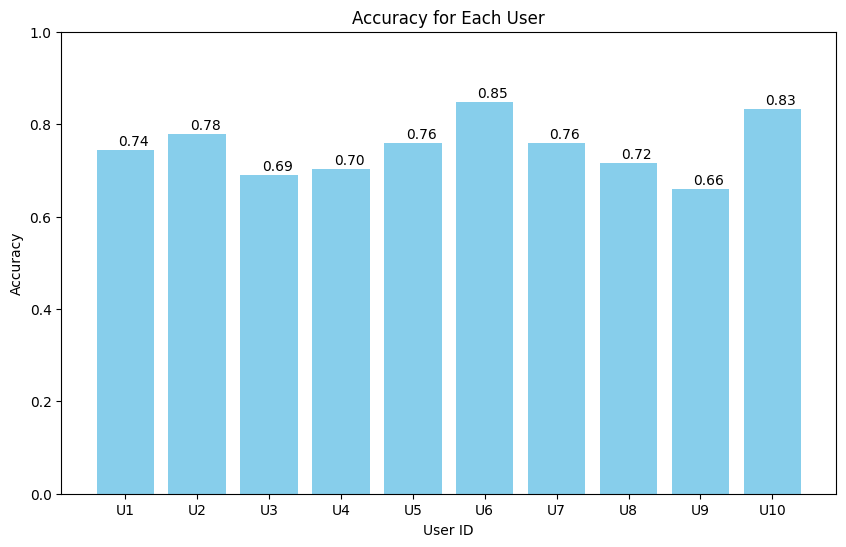

In [6]:
avg_accuracy = np.mean(accuracy_list, axis=1)

plt.figure(figsize=(10, 6))
bars = plt.bar(ID_list, avg_accuracy, color='skyblue')
for bar, accuracy in zip(bars, avg_accuracy):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.01, f'{accuracy:.2f}', fontsize=10)

plt.xlabel('User ID')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each User')
plt.ylim(0, 1)  # Set the y-axis limit to represent accuracy percentage (0 to 100%)
plt.show()